# 量子金融应用：最佳套利机会

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

当前量子计算应用到金融问题上的解决方案通常可分为三类量子算法，即量子模拟，量子优化以及量子机器学习 [1,2]。许多的金融问题本质上是一个组合优化问题，解决这些问题的算法通常具有较高的时间复杂度，实现难度较大。得益于量子计算强大的计算性能，未来有望通过量子算法解决这些复杂问题。

量桨的 Quantum Finance 模块主要讨论的是量子优化部分的内容，即如何通过一些量子算法解决实际金融应用中的优化问题。本文主要介绍如何使用量子算法求解最佳套利机会问题 [3]。

## 最佳套利机会问题

套利（Arbitrage）一般指相同的资产在不同的市场中有不同价格，可以通过在多个市场间的转换，获得正向收益。也就是说，如果给定一组资产和交易成本，那么就可能在不同市场间存在一个交易循环产生正向收益。

这个问题可以用图论的语言来描述：给定一个带权重的有向图 $G$ ，顶点 $i$ 表示一种市场货币，从顶点 $i$ 到顶点 $j$ 的边的权重表示将货币 $i$ 转换为货币 $j$的转换率 $c_{ij} $。也就是说如果拥有数量为 $x_i$ 的货币 $i$，那么通过交易转换我们将得到 $c_{ij}x_i$ 的货币 $j$。通常来讲转换率不是对称的，即 $c_{ij} \neq c_{ji}$，并且我们假设交易成本（服务供应商收取的服务费，买入和卖出时的手续费等）是已经包含在该转换率中的。

我们固定可交易的货币种类数量为 $n$，则该优化问题就是在给定的加权有向图上寻找一个获利最大回路，该回路中包含的顶点数量为 $K (K \leq n)$。找到的最佳套利回路就是从某一市场出发，使得资产转换一圈后收益最大的交易路径。在该问题中，用户可以自行定义套利回路中包含的顶点数 $K$。

## 编码最佳套利机会问题

为了将最佳套利机会问题转化成一个参数化量子电路（parameterized quantum circuits, PQC）可解的问题，我们首先需要编码该问题的哈密顿量。第一步是将该问题转化为一个整数规划问题：给定一个整数 $n$, 即最佳套利机会问题涉及的货币种类数量, 也就是图形 $G$ 的顶点数量为 $|V| = n$ 个，那么对于每个顶点 $i \in V$，我们定义 $n$ 个二进制变量 $x_{i,k}$，$k \in [0,K-1]$：

$$
x_{i, k}=\begin{cases}
1, & \text{资产转换到市场 $i$ 的次序为 $k$}\\
0, & \text{其他情况}
\end{cases}.
\tag{1}
$$

参考旅行商问题（[TSP 教程](./TSP_CN.ipynb)），因为 $G$ 有 $n$ 个顶点，所以我们共有 $n^2$ 个变量 $x_{i,k}$，所有这些变量的取值我们用 $x = x_{0,0} x_{0,1}\dots x_{n-1,K-1}$ 来表示。在这里我们假设 $x$ 对应一个套利回路，那么对于图中的每一条边 $(i,j,w_{i,j})\in E$，条件 $x_{i,k}·x_{j,k+1} = 1$ 成立当且仅当套利回路中第 $k$ 个顶点为顶点 $i$ 且 第 $k+1$ 个顶点是顶点 $j$。可以通过下面的式子计算资产在套利回路转换一圈后所获利的对数：

$$
P(x) = - \sum_{i,j\in V} \log(c_{ij}) \sum_{k=0}^{K-1}  x_{i,k}x_{j,k+1}, \tag{2}
$$

根据套利回路的定义，$x$ 如果对应一条套利回路，那么就需要满足如下的限制：

$$
\sum_{i=0}^{n-1} x_{i,k} = 1 \quad \text{和} \quad \sum_{k=0}^{K-1}\sum_{(i,j)\notin E}x_{i,k}x_{j, k+1}, \tag{3}
$$

其中第一个式子用来保证找到的 $x$ 所代表的回路中同一时刻只可能出现一个顶点，第二个保证不存在的边不会出现在最后的套利回路中。这两个式子共同保证了参数化量子电路找到的 $x$ 是个简单回路。因为后续要用梯度下降方法对损失函数进行优化求最小值，对上述式子稍作调整给出损失函数：

$$
C_x = - P(x) + A\sum_{k=0}^{K-1} \left(1 - \sum_{i=0}^{n-1} x_{i,k}\right)^2 + A\sum_{k=0}^{K-1}\sum_{(i,j)\notin E}
x_{i,k}x_{j,k+1}.
\tag{4}
$$

在这个式子中 $V$ 是图中顶点个数，$E$ 表示图中边的集合，$K$ 是套利圈中顶点的个数，$A$ 是惩罚参数，它保证了上述的限制被遵守。因为我们想要在找套利回路 $P(x)$ 最大值的同时保证 $x$ 确实表示一个回路，所以我们需要设置一个大一点的 $A$，最起码大过图 $G$ 中边的最大的权重，从而保证不遵守限制的路线不会成为最终的路线。

我们现在需要将损失函数 $C_x$ 转化为一个哈密顿量从而完成最佳套利问题的编码。每一个二进制变量可以取 $0$ 和 $1$ 两个值，分别对应量子态 $|0\rangle$ 和 $|1\rangle$。每个二进制变量都对应一个量子比特，所以我们需要 $n^2$ 个量子比特来解决最佳套利机会问题。因为我们的变量 $x_{i,k}$ 的值为 $0$ 和 $1$，所以我们要构造一个本征值和它对应的哈密顿量。泡利 $Z$ 的本征值为 $\pm 1$，于是我们构造的哈密顿量为 $\frac{I-Z}{2}$， 对应的本征值即为 $0$ 和 $1$。我们现在将二进制变量映射到这个哈密顿矩阵上，从而使 $C_x$ 转化成哈密顿矩阵：

$$
x_{i,k} \mapsto \frac{I-Z_{i,k}}{2}, \tag{5}
$$

这里 $Z_{i,k} = I \otimes I \otimes \ldots \otimes Z \otimes \ldots \otimes I$，也就是说 $Z$ 作用在位置为 $(i,k)$ 的量子比特上。通过这个映射，如果一个编号为 $(i,k)$ 的量子比特的量子态为 $|1\rangle$，那么对应的二进制变量的取值为 $x_{i,k} |1\rangle = \frac{I-Z_{i,k}}{2} |1\rangle = 1|1\rangle $，也就是说顶点 $i$ 在最佳套利回路中的交易顺序是 $k$。同样地，对于量子态为 $|0\rangle$的量子比特 $(i,k)$，它所对应的二进制变量的取值为 $x_{i,k}|0\rangle  = \frac{I-Z_{i,k}}{2} |0\rangle = 0 |0\rangle $。

我们用上述映射将 $C_x$ 转化成量子比特数为 $n^2$ 的系统的哈密顿矩阵 $H_C$，从而实现了最佳套利机会问题的量子化。这个哈密顿矩阵 $H_C$ 的基态即为最佳套利机会问题的最优解。在接下来的部分，我们将展示如何用参数化量子电路找到这个矩阵的基态，也就是对应最小本征值的本征态。

## Paddle Quantum 实现

要在量桨上实现用参数化量子电路解决量子金融中的最佳套利机会问题，首先要做的便是加载需要用到的包。其中 `networkx` 包可以帮助我们方便地查看和处理图。

In [1]:
#加载需要的包
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#加载飞桨，量桨相关的模块
import paddle
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.finance  import arbitrage_opportunities_hamiltonian

接下来，我们先生成用于最佳套利机会问题的图 $G$。为了运算方便，图中的顶点从0开始计数。

同时，为了方便运算验证，这里构造的加权有向图中对权值做了特殊设定。在实际使用过程中用户可以自行构造需要计算的货币类型，设置真实的货币汇率。

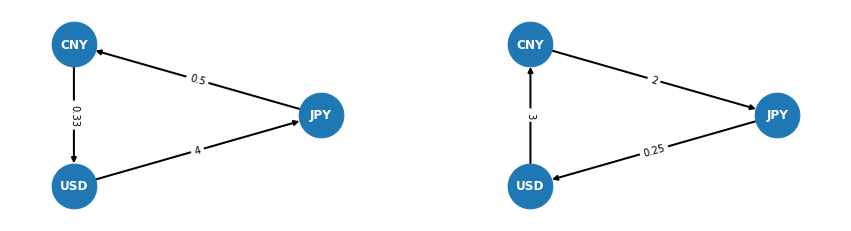

In [4]:
# n 代表图形 G 的顶点数量————指不同国家的货币
n = 3
nodes = [ "JPY", "CNY", "USD"]
G = nx.DiGraph()
G.add_nodes_from(nodes)
edges = [("JPY","CNY", 0.5), ("CNY","JPY",2), ("CNY","USD", 0.33), ("USD","CNY",3),("JPY","USD", 0.25), ("USD","JPY",4)]
G.add_weighted_edges_from(edges)

# 两幅图分别表示不同方向的转换率
G1 = nx.DiGraph()
G1.add_nodes_from(nodes)
edges1 = [("JPY","CNY", 0.5),  ("CNY","USD", 0.33), ("USD","JPY",4)]
G1.add_weighted_edges_from(edges1)

G2 = nx.DiGraph()
G2.add_nodes_from(nodes)
edges2 = [("CNY","JPY",2), ("USD","CNY",3),("JPY","USD", 0.25)]
G2.add_weighted_edges_from(edges2)

options = {
    "with_labels": True,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw(G1, pos=nx.circular_layout(G1), ax=ax[0], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G1, pos=nx.circular_layout(G1), ax=ax[0], edge_labels=nx.get_edge_attributes(G1, 'weight'))
nx.draw(G2, pos=nx.circular_layout(G2), ax=ax[1], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G2, pos=nx.circular_layout(G2), ax=ax[1], edge_labels=nx.get_edge_attributes(G2, 'weight'))
plt.axis("off")
plt.show()

### 编码哈密顿量

这里我们将式（4）中的二进制变量用式（5）替换，从而构建哈密顿量 $H_C$。

In [4]:
# 惩罚参数 等于构造的有向图中权值最大的边
penalty = 4 
# 在本样例中，设定交易回路内货币数量为全部的货币种类
K = n 
# 构建最佳套利问题的哈密顿量
hamiltonian = arbitrage_opportunities_hamiltonian(G, penalty, n, K)

### 计算损失函数

我们使用 $U_3(\vec{\theta})$ 和 $\text{CNOT}$ 门构造的参数化量子电路，通过调用量桨内部的 [`complex entangled layer`](https://qml.baidu.com/api/paddle_quantum.circuit.uansatz.html) 来实现。

上述电路会给出一个输出态 $|\vec{\theta}\rangle$，由此输出态，我们可以定义最佳套利机会问题在经典-量子混合模型下的损失函数：

$$
L(\vec{\theta}) =  \langle\vec{\theta}|H_C|\vec{\theta}\rangle.
\tag{6}
$$

之后我们利用经典的优化算法寻找最优参数 $\vec{\theta}^*$。下面的代码给出了通过量桨和飞桨搭建的完整网络：

In [5]:
class AONet(paddle.nn.Layer):

    def __init__(self, n, p, K, dtype="float64"):
        super(AONet, self).__init__()

        self.p = p
        self.num_qubits = n * K
        self.theta = self.create_parameter(shape=[self.p, self.num_qubits, 3],
            default_initializer=paddle.nn.initializer.Uniform(low=0, high=2 * np.pi),
            dtype=dtype, is_bias=False)

    def forward(self, hamiltonian):
        """
        前向传播
        """
        cir = UAnsatz(self.num_qubits)
        cir.complex_entangled_layer(self.theta, self.p)
        cir.run_state_vector()
        loss = cir.expecval(hamiltonian)

        return loss, cir


### 训练量子神经网络

定义好了量子神经网络后，我们使用梯度下降的方法来优化其中的参数，使得式（6）的期望值最小。

In [6]:
SEED = 100   # 随机数种子
p = 1        # 量子电路的层数
ITR = 120    # 迭代次数
LR = 0.4     # 梯度下降优化速率 

使用飞桨，优化上面定义的网络。

In [7]:
# 固定 paddle 随机种子
paddle.seed(SEED)

# 定义量子神经网络
net = AONet(n, p, K)

# 使用 Adam 优化器
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())
# 梯度下降优化循环
for itr in range(1, ITR + 1):
    # 运行上面定义的网络
    loss, cir = net(hamiltonian)
    #计算梯度并优化
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    if itr % 10 == 0:
        print("循环数：", itr, "    损失:", "%.4f"% loss.numpy())

循环数： 10     损失: 0.4704
循环数： 20     损失: 0.1302
循环数： 30     损失: -0.2744
循环数： 40     损失: -0.4700
循环数： 50     损失: -0.5512
循环数： 60     损失: -0.5684
循环数： 70     损失: -0.5821
循环数： 80     损失: -0.5833
循环数： 90     损失: -0.5843
循环数： 100     损失: -0.5847
循环数： 110     损失: -0.5849
循环数： 120     损失: -0.5849


### 解码量子答案

当求得损失函数的最小值以及对应的一组参数 $\vec{\mathbf{\theta}}^*$后，我们的任务还没有完成。为了进一步求得最佳套利机会问题的近似解，需要从电路输出的量子态 $|\vec{\mathbf{\theta}}^*\rangle$ 中解码出最佳套利问题的答案。物理上，解码量子态需要对量子态进行测量，然后统计测量结果的概率分布（我们的测量结果是表示最佳套利机会问题答案的比特串）：

$$
p(z) = |\langle z|\vec{\mathbf{\theta}}^*\rangle|^2.
\tag{6}
$$

在量子参数化电路表达能力足够的情况下，某个比特串出现的概率越大，意味着其是最佳套利机会问题最优解的可能性越大。

量桨提供了查看参数化量子电路输出状态的测量结果概率分布的函数：

In [8]:
# 模拟重复测量电路输出态 1024 次
prob_measure = cir.measure(shots=1024)
arbitrage_opportunity_route = max(prob_measure, key=prob_measure.get)
print("利用哈密顿量找到的解的比特串形式：", arbitrage_opportunity_route)

利用哈密顿量找到的解的比特串形式： 100001010


概率最大的测量结果是表示最佳套利机会问题答案的比特串。返回的二进制字符串每 $n$ 位一组，每组中的第 $k$ 位为 $1$ 表示该笔资产交易到该市场时的顺序为 $k$ 。如果最后的结果不是类似的有效解，读者可以通过调整参数化量子电路的参数值，即随机种子 `SEED`、层数 `p`、迭代次数 `ITR` 和梯度下降优化速率 `LR`，来获得更好的训练效果。

我们将找到的比特串映射回经典解，即转化成了 ``dictionary`` 的形式。其中 ``key`` 代表货币名称，``value`` 代表顶点在套利回路中的顺序，即一笔资产交易到该市场的顺序。在下面的代码中，我们还计算了该笔资产经找到套利回路交易一圈后的正向回报率。

In [9]:
solution = {nodes[i]:t for i in range(n) for t in range(n) if arbitrage_opportunity_route[i * n + t] == '1'}
print(solution)
rate = sum([np.log2(G[u][v]["weight"]) if solution[v] == (solution[u] + 1) % n else 0 for (u, v) in G.edges])
print("正向回报率: ", 2**rate)

{'JPY': 0, 'CNY': 2, 'USD': 1}
正向回报率:  1.5


为了清晰地表达资产的交易路径，依然选择以图的形式呈现：
* 顶点中的数字代表交易到该货币市场的顺序，字母代表不同的货币类型
* 红色的有向边表示找到的最佳路线

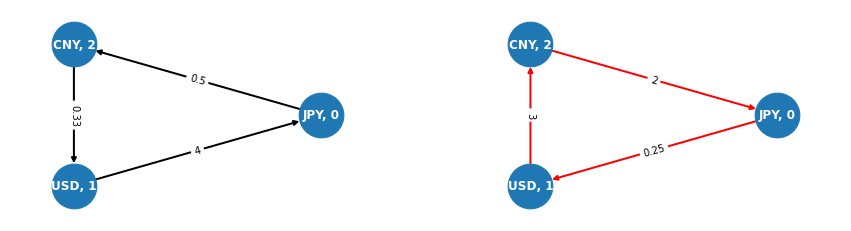

In [10]:
label_dict = {i: str(i) + ", " + str(t) for i, t in solution.items()}
edge_color1 = ["red" if solution[v] == (solution[u] + 1) % n else "black"
              for (u, v) in G1.edges]
edge_color2 = ["red" if solution[v] == (solution[u] + 1) % n else "black"
              for (u, v) in G2.edges]

# 在图上画出找到的最优路线
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw(G1, pos=nx.circular_layout(G1), labels=label_dict, edge_color=edge_color1, ax=ax[0], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G1, pos=nx.circular_layout(G1), ax=ax[0], edge_labels=nx.get_edge_attributes(G1, 'weight'))
nx.draw(G2, pos=nx.circular_layout(G2), labels=label_dict, edge_color=edge_color2, ax=ax[1], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G2, pos=nx.circular_layout(G2), ax=ax[1], edge_labels=nx.get_edge_attributes(G2, 'weight'))
plt.axis("off")
plt.show()

上面给出的左图展示了未被选中的交易路线，右图展示了该算法找到的最优套利回路。

### 结语

在本教程中，针对套利问题，给出了一种寻找最优套利回路的经典量子混合算法。对于 $n$ 个货币市场，在该解决方案中，我们需要 $n^2$ 个量子比特。在样例中，我们设定的不同市场间的汇率比较特殊且把交易成本包含在内，所以会产生高达 $150\%$ 的正向收益率。用户在使用时可以根据需求，自行设定真实的货币汇率。

在实际的金融市场中，一般不会有如此高的投资回报率，而且考虑的货币市场数量比较大，需要考虑的因素也更多。因此，随着货币数量的增加，所需的量子比特数也急速增加，实现难度也就越大。

_______

## 参考文献

[1] Orus, Roman, Samuel Mugel, and Enrique Lizaso. "Quantum computing for finance: Overview and prospects." [Reviews in Physics 4 (2019): 100028.](https://arxiv.org/abs/1807.03890)

[2] Egger, Daniel J., et al. "Quantum computing for Finance: state of the art and future prospects." [IEEE Transactions on Quantum Engineering (2020).](https://arxiv.org/abs/2006.14510)

[3] Rosenberg, G. "Finding optimal arbitrage opportunities using a quantum annealer." [1QB Information Technologies Write Paper (2016): 1-7.](https://1qbit.com/whitepaper/arbitrage/)